# Модель предсказания цены машины

**AutoML от сбербанка**

Чтобы установить LAMA на последней версии питона потребовалось найти на форуме ответ одного из разработчиков (команда с нужной версией выглядит как *!pip install -U lightautoml==0.3.8b1*)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch
import category_encoders as ce
from sklearn import preprocessing

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

Зададим константы для параметров будущей модели

In [ ]:
N_THREADS = 5
N_FOLDS = 6
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1800
TARGET_NAME = 'final_price'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [ ]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
submission = pd.read_csv('submission.csv')

Функционал LAMA позволяет узнать важность признаков, вот график из одного из моих прошлых исследований 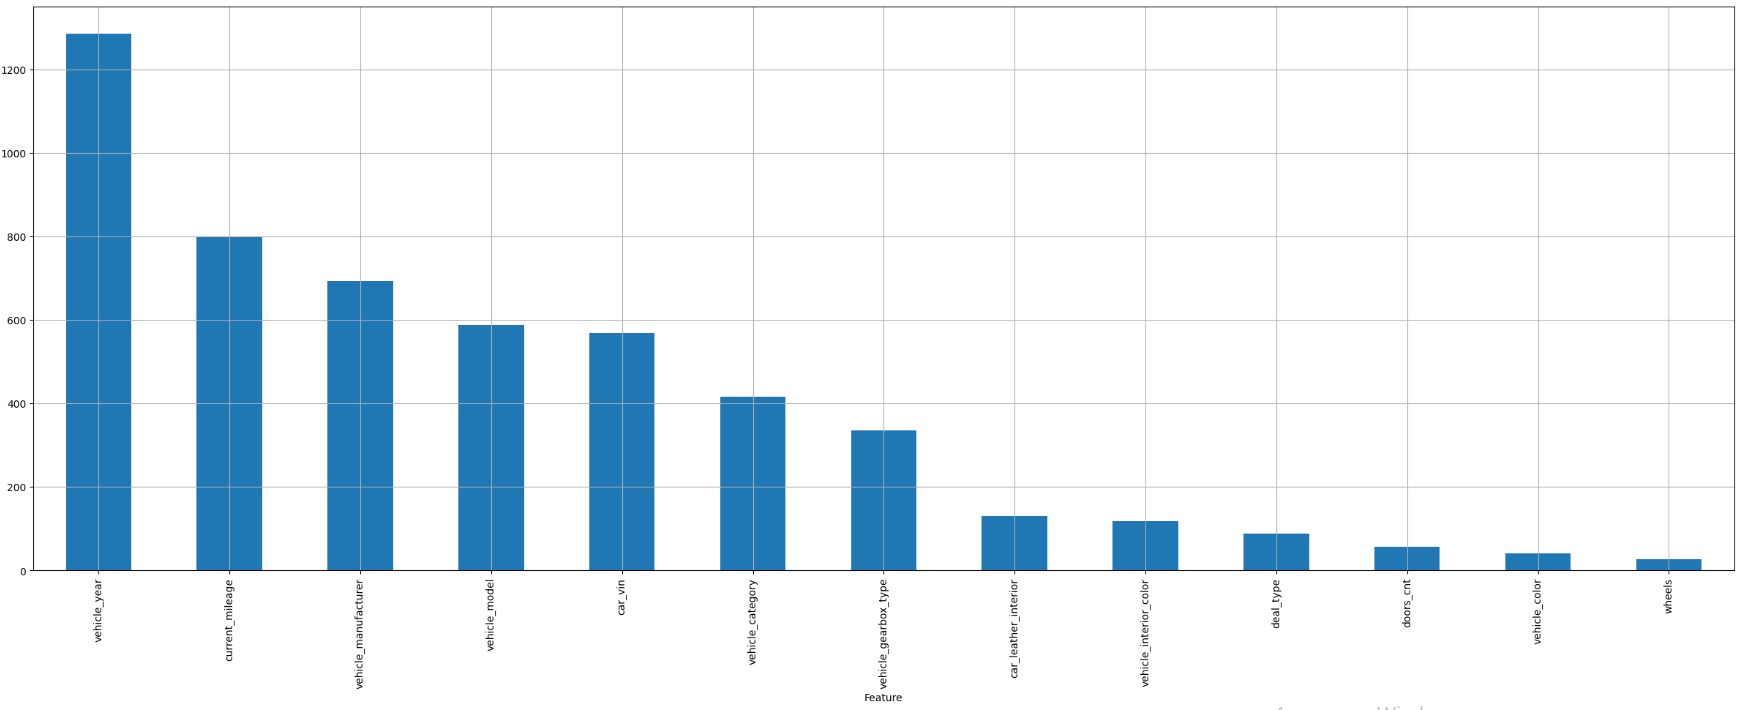

Попробуем исключить выбросы по самым важным признакам (значения были взяты из графиков распределния значений признаков)

In [ ]:
original_rows_count = train_data.shape[0]
train_data.drop(train_data[(train_data['final_price'] == 0)].index, inplace=True)
train_data.drop(train_data[(train_data['final_price'] >= 90000)].index, inplace=True)
train_data.drop(train_data[(train_data['final_price'] >= 600) & (train_data['deal_type'] != 'For Sale')].index, inplace=True)
train_data.drop(train_data[(train_data['current_mileage'] > 1000000) & (train_data['deal_type'] != 'For Sale')].index, inplace=True)
train_data.drop(train_data[(train_data['current_mileage'] > 1000000) & (train_data['deal_type'] == 'For Sale')].index, inplace=True)
train_data.drop(train_data[(train_data['current_mileage'] > 5000000) & (train_data['deal_type'] == 'For Sale') & (train_data['final_price'] > 4000)].index, inplace=True)
train_data.drop(train_data[(train_data['vehicle_year'] < 1986) & (train_data['deal_type'] != 'For Sale')].index, inplace=True)
train_data.drop(train_data[(train_data['vehicle_year'] < 1986) & (train_data['deal_type'] == 'For Sale') & (train_data['final_price'] > 5000)].index, inplace=True)
print(f'Было: {original_rows_count}, осталось: {train_data.shape[0]}')

Было: 35000, осталось: 34784


Создадим новые признаки: значения в столбцах с категориальными признаками выделим в новые столбцы

In [ ]:
def create_expert_feats(data):
    data['for_sale'] = data['deal_type'].apply(lambda x: 1 if x == 'For Sale' else 0)

    data['wheels'] = data['wheels'].str.strip()
    data['wheels'] = data['wheels'].fillna('Left wheel')
    data['left_wheel'] = data['wheels'].apply(lambda x: 0 if x == 'Right-hand drive' else 1)

    data['vehicle_interior_color'] = data['vehicle_interior_color'].str.strip()
    data['vehicle_interior_color'] = data['vehicle_interior_color'].fillna('na')

    data['doors_cnt'] = data['doors_cnt'].str.strip()
    doors_cnt_by_model = data.groupby(['vehicle_model', 'vehicle_category', 'vehicle_gearbox_type'], as_index = False)['doors_cnt'].first()
    data = data.merge(doors_cnt_by_model, on=['vehicle_model', 'vehicle_category', 'vehicle_gearbox_type'], how='left', suffixes=('', '_new'))
    data['doors_cnt_new'] = data['doors_cnt_new'].fillna('4/5')

    data['vehicle_model'] = data['vehicle_model'].fillna('na')

    data['vehicle_manufacturer'] = data['vehicle_manufacturer'].fillna('na')

    data['vehicle_manuf_model'] = data.apply(lambda x: ' '.join([x.vehicle_manufacturer, x.vehicle_model]), axis=1)
    data['vehicle_manuf_model_crop_1'] = data.apply(lambda x: ' '.join([x.vehicle_manufacturer, x.vehicle_model.split()[0] if x.vehicle_model else '']), axis=1)
    data['vehicle_model_crop_1'] = data['vehicle_model'].apply(lambda x: x.split()[0] if x else '')
    data['vehicle_model_crop_2'] = data['vehicle_model'].apply(lambda x: ' '.join(x.split()[:2]))
    data['vehicle_model_crop_3'] = data['vehicle_model'].apply(lambda x: x.split()[1] if len(x.split())>1 else '')

    data = pd.get_dummies(
        data,
        drop_first=True,
        columns=[
            'vehicle_color',
            'vehicle_interior_color',
            'vehicle_category',
            'doors_cnt_new',
            'vehicle_gearbox_type'
        ]
    )

    object_columns = [s for s in data.columns if data[s].dtypes == 'object']

    data.drop(['doors_cnt', 'deal_type', 'wheels'], axis = 1, inplace=True)
    return data

train_data['sample'] = 1
test_data['sample'] = 0
test_data['final_price'] = 0
common_data = train_data.append(test_data, sort=False).reset_index(drop=True)
common_data = create_expert_feats(common_data)

train_data = common_data[common_data['sample'] == 1].copy()
test_data = common_data[common_data['sample'] == 0].copy()

train_data.drop(['sample'], axis = 1, inplace=True)
test_data.drop(['sample'], axis = 1, inplace=True)

<ipython-input-10-f99540693948>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  common_data = train_data.append(test_data, sort=False).reset_index(drop=True)


Будем обучать две модели: машины на продажу и машины в аренду.

In [ ]:
train_data_s = train_data[train_data['for_sale'] == 1]
train_data_r = train_data[train_data['for_sale'] == 0]

test_data_s = test_data[test_data['for_sale'] == 1]
test_data_r = test_data[test_data['for_sale'] == 0]

tr_data_s, te_data_s = train_test_split(
    train_data_s,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

tr_data_r, te_data_r = train_test_split(
    train_data_r,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [ ]:
tr_data, te_data = train_test_split(
    train_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27827, 56), te_data = (6957, 56)


,row_ID,vehicle_manufacturer,vehicle_model,current_mileage,vehicle_year,car_vin,car_leather_interior,final_price,for_sale,left_wheel,...,vehicle_category_Microbus,vehicle_category_Minivan,vehicle_category_Pickup,vehicle_category_Sedan,vehicle_category_Universal,doors_cnt_new_4/5,doors_cnt_new_>5,vehicle_gearbox_type_Manual,vehicle_gearbox_type_Tiptronic,vehicle_gearbox_type_Variator
10520,10578,HYUNDAI,Elantra,112243,2012,NaN,1,6097.0,1,1,...,0,0,0,1,0,1,0,0,0,0
28663,28835,BMW,X6,164354,2011,5UXFG2C50BLX05471,1,15700.0,1,1,...,0,0,0,0,0,1,0,0,1,0
18415,18519,VOLKSWAGEN,Passat,100000,2015,NaN,1,4500.0,1,1,...,0,0,0,1,0,1,0,0,1,0
18633,18738,CHEVROLET,Cruze RS LT,193334,2013,NaN,0,4800.0,1,1,...,0,0,0,1,0,1,0,0,1,0
6830,6865,AUDI,Q5,120000,2013,WA1LFAFP0DA016697,1,14300.0,1,1,...,0,0,0,0,0,1,0,0,1,0


Параметры для 2 моделей

In [ ]:
task = Task('reg', loss = 'mae', metric = 'mae')

roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

automl_s = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
automl_r = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Обучение

In [ ]:
oof_pred_s = automl_s.fit_predict(tr_data_s, roles = roles, verbose = 1)
oof_pred_r = automl_r.fit_predict(tr_data_r, roles = roles, verbose = 1)

[12:06:25] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[12:06:25] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[12:06:25] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[12:06:25] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[12:06:25] - time: 1800.00 seconds


INFO:lightautoml.automl.presets.base:- time: 1800.00 seconds


[12:06:25] - CPU: 5 cores


INFO:lightautoml.automl.presets.base:- CPU: 5 cores


[12:06:25] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[12:06:25] Train data shape: (27352, 56)



INFO:lightautoml.reader.base:Train data shape: (27352, 56)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[12:06:35] Layer 1 train process start. Time left 1789.53 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 1789.53 secs


[12:06:37] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 63}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -3655.8702435686964
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -3650.6831809761597
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -3644.3515953805318
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -3594.137577285315
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -3535.361516947076
INFO3:lightautom

[12:06:56] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2439.6994058185587


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2439.6994058185587


[12:06:56] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[12:06:56] Time left 1769.26 secs



INFO:lightautoml.automl.base:Time left 1769.26 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 2069.16
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 1939.07
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 1898.63
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 1869.71
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 1851.96
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 1839.32
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 1831.73
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 1825.72
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 1816.1
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's l1: 1808.46
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's l1: 1803.27
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's l1: 1796.11
DEBUG:lightautoml.ml_algo.boost_lgbm:Did not meet early stopping. Best iteration is:
[1200

[12:07:01] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[12:07:03] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.03, 'num_leaves': 32, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.5, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 1200, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 1820.99
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 1713.9
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 1697.21
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 1680.61
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l

[12:07:55] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1714.5496051133318


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1714.5496051133318


[12:07:55] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[12:07:55] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 197.77 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 197.77 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-bcf72a9e-48ef-409e-a358-72971704305d
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 1647.84
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 1536.87
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 1518.24
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 1508.1
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 1500.37
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 1494.84
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 1489.98
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 1487.91
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 1486.58
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's l1: 1485.33
DEBUG:ligh

[12:11:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -1482.2500 mae


[12:11:21] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 1540.1
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 1503.56
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid'

[12:14:34] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1547.9656538878505


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1547.9656538878505


[12:14:34] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[12:14:34] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 3645.0584585	test: 3561.2862775	best: 3561.2862775 (0)	total: 63.4ms	remaining: 2m 6s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2079.3762728	test: 2037.8185919	best: 2037.8185919 (100)	total: 1.1s	remaining: 20.7s
DEBUG:lightautoml.ml_algo.

[12:15:37] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1770.18157577278


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1770.18157577278


[12:15:37] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[12:15:37] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-dcc59f3a-7f73-4238-bbe1-9f790045067a
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 3646.0822202	test: 3562.1236541	best: 3562.1236541 (0)	total: 4.86ms	remaining: 9.71s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2150.7849649	test: 2124.8733270	best: 2124.8733270 (100)	total: 420ms	remaining: 7.89s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1993.1167456	test: 1962.9006949	best: 1962.9006949 (200)	total: 852ms	remaining: 7.62s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1902.2972321	test: 1876.4515523	best: 1876.4515523 (300)	total: 1.29s	remaining: 7.27s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 1862.0431023	test: 1838.4775007	best: 1838.4775007 (400)	total: 1.72s	remaining: 6.86s
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 1830.2479624	test: 1813.9

[12:20:37] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 7, 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}
 achieve -1577.4960 mae


[12:20:37] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 8.148018307012941e-07, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 3678.5102347	test: 3596.0957143	best: 3596.0957143 (0)	total: 7.02ms	remaining: 21.1s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 2068.5386081	test: 2038.1765211	best: 2038.1765211 (100)	total: 710ms	remaining: 20

[12:22:31] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1698.8554128471453


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1698.8554128471453


[12:22:31] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[12:22:31] Time left 833.44 secs



INFO:lightautoml.automl.base:Time left 833.44 secs



[12:22:31] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[12:22:31] Blending: optimization starts with equal weights and score -1738.2771997065981


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -1738.2771997065981


[12:22:32] Blending: iteration 0: score = -1547.9656538878505, weights = [0. 0. 1. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -1547.9656538878505, weights = [0. 0. 1. 0. 0.]


[12:22:32] Blending: iteration 1: score = -1547.9656538878505, weights = [0. 0. 1. 0. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -1547.9656538878505, weights = [0. 0. 1. 0. 0.]


[12:22:32] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[12:22:32] Automl preset training completed in 966.89 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 966.89 seconds



[12:22:32] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (6 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (6 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 



[12:22:32] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[12:22:32] Task: reg



INFO:lightautoml.automl.presets.base:Task: reg



[12:22:32] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[12:22:32] - time: 1800.00 seconds


INFO:lightautoml.automl.presets.base:- time: 1800.00 seconds


[12:22:32] - CPU: 5 cores


INFO:lightautoml.automl.presets.base:- CPU: 5 cores


[12:22:32] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[12:22:32] Train data shape: (475, 56)



INFO:lightautoml.reader.base:Train data shape: (475, 56)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[12:22:42] Layer 1 train process start. Time left 1789.82 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 1789.82 secs


[12:22:42] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87], 'embed_sizes': array([ 2, 10,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3], dtype=int32), 'data_size': 88}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -15.830663919448853
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -15.704620444774628
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0

[12:23:02] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -11.980983705018696


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -11.980983705018696


[12:23:02] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[12:23:02] Time left 1769.72 secs



INFO:lightautoml.automl.base:Time left 1769.72 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 12.6139
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 11.478
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 11.2682
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 11.1406
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 11.0721
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 11.0496
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 11.0224
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 11.0096
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 10.9767
DEBUG:lightautoml.ml_algo.boost_lgbm:[1000]	valid's l1: 10.9695
DEBUG:lightautoml.ml_algo.boost_lgbm:[1100]	valid's l1: 10.9468
DEBUG:lightautoml.ml_algo.boost_lgbm:[1200]	valid's l1: 10.9371
DEBUG:lightautoml.ml_algo.boost_lgbm:[1300]	valid's l1: 10.926
DEBUG:lightautoml.ml_algo.b

[12:23:03] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[12:23:03] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 12.4902
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 11.5028
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 11.1122
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 10.9643
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1

[12:23:11] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -10.881955233122174


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -10.881955233122174


[12:23:11] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[12:23:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-80f7638b-ca78-4ebb-8213-c2156745e39c
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 12.5615
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 11.6192
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's l1: 11.1553
DEBUG:lightautoml.ml_algo.boost_lgbm:[400]	valid's l1: 11.0614
DEBUG:lightautoml.ml_algo.boost_lgbm:[500]	valid's l1: 10.9884
DEBUG:lightautoml.ml_algo.boost_lgbm:[600]	valid's l1: 10.913
DEBUG:lightautoml.ml_algo.boost_lgbm:[700]	valid's l1: 10.8676
DEBUG:lightautoml.ml_algo.boost_lgbm:[800]	valid's l1: 10.8714
DEBUG:lightautoml.ml_algo.boost_lgbm:[900]	valid's l1: 10.8761
DEBUG:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[7

[12:25:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.8741239047249859, 'num_leaves': 199, 'bagging_fraction': 0.9895810892549581, 'min_sum_hessian_in_leaf': 8.710292517667634, 'reg_alpha': 5.1904092689177375e-08, 'reg_lambda': 1.6928397261275414e-07}
 achieve -10.4050 mae


[12:25:39] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 199, 'feature_fraction': 0.8741239047249859, 'bagging_fraction': 0.9895810892549581, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 5.1904092689177375e-08, 'reg_lambda': 1.6928397261275414e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 8.710292517667634}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[100]	valid's l1: 10.8775
DEBUG:lightautoml.ml_algo.boost_lgbm:[200]	valid's l1: 10.777
DEBUG:lightautoml.ml_algo.boost_lgbm:[300]	valid's 

[12:25:44] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -10.720064849853516


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -10.720064849853516


[12:25:44] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[12:25:44] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 300, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 15.1449355	test: 15.6231237	best: 15.6231237 (0)	total: 3.35ms	remaining: 6.7s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 9.3777505	test: 10.7558017	best: 10.7524287 (96)	total: 128ms	remaining: 2.4s
DEBUG:lightautoml.ml_algo.boost_cb:200:	l

[12:25:48] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -10.566151681197317


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -10.566151681197317


[12:25:48] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[12:25:48] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-5a188410-4026-4a82-8eca-84e1b46395b2
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 15.1540494	test: 15.6306237	best: 15.6306237 (0)	total: 2.57ms	remaining: 5.13s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 10.1864189	test: 11.4399519	best: 11.4399519 (100)	total: 73.1ms	remaining: 1.37s
DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 8.7024098	test: 10.5716413	best: 10.5716413 (200)	total: 125ms	remaining: 1.12s
DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 7.6806121	test: 10.6218150	best: 10.2906288 (256)	total: 177ms	remaining: 1s
DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 7.0625637	test: 10.7767124	best: 10.2906288 (256)	total: 237ms	remaining: 947ms
DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 6.7125821	test: 10.9269623	best: 10.2906288 (256)	total: 294

[12:27:21] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 6, 'l2_leaf_reg': 0.19161547720914934, 'min_data_in_leaf': 19}
 achieve -8.9925 mae


[12:27:21] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.19161547720914934, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 19, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 15.2258722	test: 15.7121237	best: 15.7121237 (0)	total: 1.77ms	remaining: 5.31s
DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 10.1573892	test: 11.3332366	best: 11.3332366 (100)	total: 207ms	remaining: 5.95s
DEBUG:lig

[12:27:26] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -10.608227384466874


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -10.608227384466874


[12:27:26] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[12:27:26] Time left 1505.41 secs



INFO:lightautoml.automl.base:Time left 1505.41 secs



[12:27:26] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[12:27:26] Blending: optimization starts with equal weights and score -10.678576742473401


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score -10.678576742473401


[12:27:26] Blending: iteration 0: score = -10.485874147917094, weights = [0.         0.         0.17161088 0.61502534 0.21336375]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -10.485874147917094, weights = [0.         0.         0.17161088 0.61502534 0.21336375]


[12:27:26] Blending: iteration 1: score = -10.484141359831158, weights = [0.         0.         0.26220897 0.5603604  0.17743066]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = -10.484141359831158, weights = [0.         0.         0.26220897 0.5603604  0.17743066]


[12:27:26] Blending: iteration 2: score = -10.484106230484812, weights = [0.         0.         0.2648981  0.55585164 0.17925031]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = -10.484106230484812, weights = [0.         0.         0.2648981  0.55585164 0.17925031]


[12:27:27] Blending: iteration 3: score = -10.484106330871581, weights = [0.         0.         0.2649072  0.5558363  0.17925648]


INFO:lightautoml.automl.blend:Blending: iteration 3: score = -10.484106330871581, weights = [0.         0.         0.2649072  0.5558363  0.17925648]


[12:27:27] Blending: iteration 4: score = -10.484106330871581, weights = [0.         0.         0.2649072  0.5558363  0.17925648]


INFO:lightautoml.automl.blend:Blending: iteration 4: score = -10.484106330871581, weights = [0.         0.         0.2649072  0.5558363  0.17925648]


[12:27:27] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[12:27:27] Automl preset training completed in 294.84 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 294.84 seconds



[12:27:27] Model description:
Final prediction for new objects (level 0) = 
	 0.26491 * (6 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.55584 * (6 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.17926 * (6 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.26491 * (6 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.55584 * (6 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.17926 * (6 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



In [ ]:
te_pred_s = automl_s.predict(te_data_s)
te_pred_r = automl_r.predict(te_data_r)

In [ ]:
tr_data = pd.concat([tr_data_s, tr_data_r])
te_data = pd.concat([te_data_s, te_data_r])
oof_pred = np.concatenate((oof_pred_s.data[:, 0], oof_pred_r.data[:, 0]))
te_pred = np.concatenate((te_pred_s.data[:, 0], te_pred_r.data[:, 0]), axis=0)

**Ошибка для машин на продажу**

In [ ]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data_s[TARGET_NAME].values, oof_pred_s.data[:,0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data_s[TARGET_NAME].values, te_pred_s.data[:,0])}')

TRAIN out-of-fold score: 1547.9656538878505
HOLDOUT score: 1418.1745884826428


**Ошибка для машин в аренду**

In [ ]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data_r[TARGET_NAME].values, oof_pred_r.data[:,0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data_r[TARGET_NAME].values, te_pred_r.data[:,0])}')

TRAIN out-of-fold score: 10.484100578709652
HOLDOUT score: 11.956863683812758


**Ошибка для всех машин**

In [ ]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred)}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred)}')

TRAIN out-of-fold score: 1521.7212244552188
HOLDOUT score: 1394.1211302030595


Предсказываем значения

In [ ]:
test_pred_s = automl_s.predict(te_data_s)
test_pred_r = automl_r.predict(te_data_r)
test_pred = np.concatenate((test_pred_s.data[:, 0], test_pred_r.data[:, 0]))
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
[2783.068    5491.8403   2285.2317   ...   30.348497   13.749945
   34.318512]
Shape = (10697,)


In [ ]:
test_data_copy = pd.concat((test_data_s, test_data_r))
test_data_copy['result'] = test_pred
test_data_copy = test_data_copy.sort_index()
result = test_data_copy['result']

submission[TARGET_NAME] = np.array(result)
submission

,row_ID,final_price
0,35000,2783.068115
1,35001,5491.840332
2,35002,2285.231689
3,35003,768.289124
4,35004,4486.895508
...,...,...
10692,45692,292.762299
10693,45693,1642.607178
10694,45694,17263.617188
10695,45695,5316.709961
